### Adaboost Exercise
- Following example on [this blog post](https://geoffruddock.com/adaboost-from-scratch-in-python/) and [this blog](https://xavierbourretsicotte.github.io/AdaBoost.html)
- Algorithm summary
    1. initialize sample weights as $w_i^1 = \frac{1}{n}$
    2. For each interation $t$:
         - 2.1. Fit data to decision tree stump to minimize $\epsilon_t = \frac{\sum_{i=1}^{n}\mathbf{1}[h_t(x_i)\ne y_i]w_i^{(t)}}{\sum_i^nw_i^{t}}$  (sum of weights for all incorrect predictions. $\sum_i^nw_i{(t)}=1$, the denominator just disappears)
         - 2.2. Set weight for the current decision tree stump as $\alpha_t = \frac{1}{2}\ln(\frac{1-\epsilon_t}{\epsilon_t})$
         - 2.3. Update sample weights as $w_i^{(t+1)} = w_i^{(t)}\cdot e^{-\alpha^ty_ih_t(x_i)}$ (since $ty_ih_t(x_i)$ is always 1 for correct prediction and -1 for incorrect ones, weights will increase for wrong samples and shrink for correct ones)
         - 2.4. Renormalize weights, so that $\sum_{i=1}^{n}w_i^{(t+1)}=1$
    3. Bring all decision tree stumps togeter as weighted majority vote: $H(x) = sign(\sum_{t=1}^T=\alpha_th_t(x))$

In [1]:
# import sklearn version of adaboost for comparison
# import decision tree from sklearn to use as tree stump
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
from typing import Optional
import matplotlib as mpl

def plot_adaboost(X: np.ndarray,
                  y: np.ndarray,
                  clf=None,
                  sample_weights: Optional[np.ndarray] = None,
                  annotate: bool = False,
                  ax: Optional[mpl.axes.Axes] = None) -> None:
    """ Plot ± samples in 2D, optionally with decision boundary if model is provided. """

    assert set(y) == {-1, 1}, 'Expecting response labels to be ±1'

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
        fig.set_facecolor('white')

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = np.array(sample_weights) * X.shape[0] * 100
    else:
        sizes = np.ones(shape=X.shape[0]) * 100

    X_pos = X[y == 1]
    sizes_pos = sizes[y == 1]
    ax.scatter(*X_pos.T, s=sizes_pos, marker='+', color='red')

    X_neg = X[y == -1]
    sizes_neg = sizes[y == -1]
    ax.scatter(*X_neg.T, s=sizes_neg, marker='.', c='blue')

    if clf:
        plot_step = 0.01
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['r']
        else:
            fill_colors = ['b', 'r']

        ax.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)

    if annotate:
        for i, (x, y) in enumerate(X):
            offset = 0.05
            ax.annotate(f'$x_{i + 1}$', (x + offset, y - offset))

    ax.set_xlim(x_min+0.5, x_max-0.5)
    ax.set_ylim(y_min+0.5, y_max-0.5)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

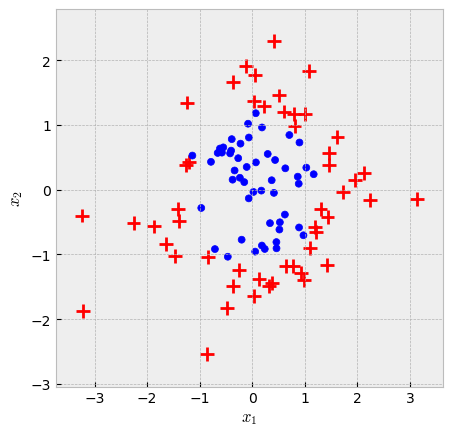

In [7]:
# generate fake dataset

from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

def make_toy_dataset(n: int = 100, random_seed: int = None) -> (np.ndarray, np.ndarray):
    """ Generate a toy dataset for evaluating AdaBoost classifiers
    
    Source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
    
    """
    
    n_per_class = int(n/2)
    
    if random_seed:
        np.random.seed(random_seed)

    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    
    return X, y*2-1

X, y = make_toy_dataset(n=100, random_seed=1024)
plot_adaboost(X, y)

Train error: 3.0%


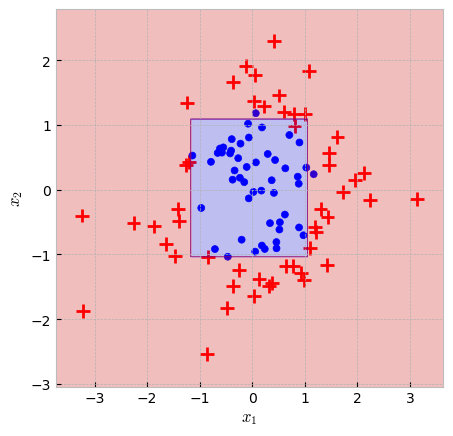

In [9]:
# run sklearn adaboost on fake data and plot
adaboost_sk = AdaBoostClassifier(n_estimators=10, algorithm='SAMME').fit(X, y)
plot_adaboost(X, y, adaboost_sk)
train_err = (adaboost_sk.predict(X) != y).mean()
print(f'Train error: {train_err:.1%}')

In [32]:
class AdaBoost():
    # initialize with parameters
    def __init__(self):
        self.stumps = None
        self.alphas = None # alphas are weights for tree stumps
        self.errors = None
        self.weights = None # sample weights
    
    # function for fit 
    def fit(self, X: np.ndarray, y: np.ndarray, n_iters: int=10):
        # check if true labels consist of only -1 and 1
        assert set(y) == {-1, 1}, 'Expecting response variable to be formatted as -1 or 1'
        n = X.shape[0]
        # initialize class parameters
        self.weights = np.zeros(shape=(n_iters, n))
        self.stumps = np.zeros(shape=n_iters, dtype=object)
        self.alphas = np.zeros(shape=n_iters)
        self.errors = np.zeros(shape=n_iters)
        # for the 1st round, set all sample weights to be 1/n
        self.weights[0] = np.ones(shape=n)/n
        # start training iteration
        for t in range(n_iters):
            # find the sample weights coprresonding to the current stump
            current_weights = self.weights[t]
            # initialize tree stump
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            # fit the tree stump with current sample weights
            stump.fit(X, y, sample_weight=current_weights)
            
            # predict using tree stump
            stump_pred = stump.predict(X)
            # calculate error rate
            err = current_weights[stump_pred!=y].sum()
            # set alpha using the error rate
            alpha = np.log((1-err)/err) / 2
            
            # update sample weights
            new_weights = current_weights * np.exp(-alpha * y * stump_pred)
            new_weights /= new_weights.sum()
            
            # updadte sample weights
            # weights are used for the next iteration, so t+1
            if t+1 < n_iters:
                self.weights[t+1] = new_weights
            
            # save iteration results
            self.stumps[t] = stump
            self.alphas[t] = alpha
            self.errors[t] = err  
        return self
    
    # function for prediction
    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        return np.sign(np.dot(self.alphas, stump_preds))

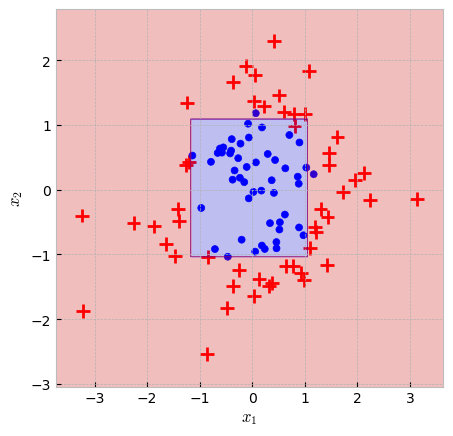

In [33]:
ada = AdaBoost()
ada.fit(X, y)
plot_adaboost(X, y, ada)